# 1. Data Importing

In [21]:
import imutils
from imutils import face_utils
import time
import dlib
import cv2
import logging
import json
logging.disable(logging.INFO)
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

import torch.utils.data as utils_data
import torch
from torch import nn
import torchvision.models as models

In [2]:
data_path = 'dataset/ck/'
df = pd.read_csv(data_path + 'df_vector_coods_sep.csv', index_col='filename')
df['vectors'] = df['vectors'].apply(json.loads)
df['coords'] = df['coords'].apply(json.loads)
df = df[df.mood != "contempt"] # drop contempt values
display(df.sample(10))

,mood,vectors,coords
filename,,,
S504_006_00000001.png,neutral,"[[0.9372048555019711, -2.724543411601308], [0....","[-0.8568753083836917, -0.3796283011826483, -0...."
S117_003_00000014.png,fear,"[[0.9432132894210241, -2.728463821311392], [0....","[-0.8638599574275754, -0.3786783375024988, -0...."
S130_003_00000001.png,neutral,"[[0.9072880226456376, -2.603370951978315], [0....","[-0.779017104463638, -0.4650848384857541, -0.7..."
S105_001_00000001.png,neutral,"[[0.9726178085249385, -2.677945044588987], [0....","[-0.8699358143954548, -0.4349679071977274, -0...."
S138_003_00000001.png,neutral,"[[0.9457122325692678, -2.7367008673047097], [0...","[-0.8692466983933241, -0.3725342993114246, -0...."
S035_001_00000015.png,surprise,"[[0.9055385138137415, -2.646705211158719], [0....","[-0.7968939703624315, -0.4300697617828995, -0...."
S057_003_00000001.png,neutral,"[[0.9110742865797912, -2.6559705602923245], [0...","[-0.8057402077620979, -0.42525177631888494, -0..."
S090_002_00000011.png,surprise,"[[0.7954345035153529, -2.646705211158719], [0....","[-0.7000000000000001, -0.37777777777777777, -0..."
S095_001_00000001.png,neutral,"[[0.9648130376041072, -2.784283970581693], [0....","[-0.9038769075777341, -0.3374473788290207, -0...."


# 2. Build FCNN

In [3]:
class FCNNModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super(FCNNModel, self).__init__()
        
        input_layer_size = kwargs['input_layer_size']
        hidden_layer_size = kwargs['hidden_layer_size']
        num_classes = kwargs['num_classes']
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_layer_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, num_classes),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [151]:
class emotion_recognition_model(object):
    def __init__(self, hidden_layer_size=512):
        self.hidden_layer_size = hidden_layer_size
        self.path = './trained_models/FCNN_state_dicts/FCNN_model-%d.pkl' % self.hidden_layer_size
        
    def build(self, input_layer_size, num_classes):
        self.model = FCNNModel(input_layer_size=input_layer_size, hidden_layer_size=self.hidden_layer_size, num_classes=num_classes)
        if torch.cuda.is_available():
            self.model = self.model.cuda()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001, weight_decay=0.0001)
        self.loss_func = nn.CrossEntropyLoss()
        
    def train(self, loaders, epochs=200, print_epoch=50, save=True):
        self.epochs = epochs
        train_loader, test_loader = loaders[0], loaders[1]
        self.train_losses, self.test_losses = [], []
        self.train_accuracies, self.test_accuracies = [], []
        if best_accuracies.get(self.hidden_layer_size) is None:
            best_accuracies[self.hidden_layer_size] = 0
        for epoch in range(self.epochs): # 200
            running_loss, ev_loss = 0.0, 0.0
            train_acc = 0.0
            for step, (batch_image, batch_label) in enumerate(train_loader):
                self.model.train()
                if torch.cuda.is_available():
                    batch_image, batch_label = batch_image.cuda(), batch_label.cuda()
                batch_output = self.model(batch_image)
                batch_loss = self.loss_func(batch_output, batch_label)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                running_loss += batch_loss.item()

                # train accuracy
                _, train_predicted = torch.max(batch_output.data, 1)
                train_acc += (train_predicted == batch_label).sum().item()

            train_acc /= train_size
            running_loss /= (step+1)
            self.train_losses.append(running_loss)
            self.train_accuracies.append(train_acc)

            # ----------test----------
            self.model.eval()
            test_acc = 0.0
            for step, (test_image, test_label) in enumerate(test_loader):
                if torch.cuda.is_available():
                    test_image, test_label = test_image.cuda(), test_label.cuda()                
                test_output = self.model(test_image)
                _, predicted = torch.max(test_output.data, dim=1)
                test_acc += (predicted == test_label).sum().item()

                batch_loss = self.loss_func(test_output, test_label)
                ev_loss += batch_loss.item()

            test_acc /= test_size
            ev_loss /= (step+1)
            self.test_losses.append(ev_loss)
            self.test_accuracies.append(test_acc)

            if (not (epoch % print_epoch)) or (epoch == epochs-1):
                print('epoch={:d}\ttrain loss={:.6f}\ttest loss={:.6f}\ttrain accuracy={:.3f}\ttest accuracy={:.3f}'.format(
                    epoch, running_loss, ev_loss, train_acc, test_acc))

            if save:
                if test_acc >= best_accuracies[self.hidden_layer_size]:
                    torch.save(self.model.state_dict(), self.path)
                    best_accuracies[self.hidden_layer_size] = test_acc
                
    def visualize(self, figsize=(12,3.6), loss_range=0, acc_range=0):
        loss_range = loss_range if loss_range else self.epochs
        acc_range = acc_range if acc_range else self.epochs
        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.set_size_inches(figsize[0], figsize[1])
        fig.suptitle('Hidden layer size: %d' % self.hidden_layer_size)
        ax1.set_title("Cross Entropy Loss")
        ax1.plot([k for k in range(self.epochs)], self.train_losses, label="train")
        ax1.plot([k for k in range(self.epochs)], self.test_losses, label="test")
        ax1.set_xlim(0,loss_range)
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.legend(loc='upper right')

        ax2.set_title("Accuracy")
        ax2.plot([k for k in range(self.epochs)], self.train_accuracies, label="train")
        ax2.plot([k for k in range(self.epochs)], self.test_accuracies, label="test: %.3f" % best_accuracies[self.hidden_layer_size])
        ax2.set_xlim(0,acc_range)
        ax2.set_ylim(0,1.1)
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Accuracy")
        ax2.legend(loc='lower right')

# 3. Load Data

In [5]:
num_samples = df.shape[0]

vectors = np.array([k for k in df['vectors'].values]).reshape(num_samples, -1)
coords = np.array([k for k in df['coords'].values])
Vector = np.dstack((vectors, coords)).reshape(num_samples, -1) # shape=(samples, vectors+coords)

moods = ["anger","disgust","fear","happiness","neutral","sadness","surprise"]
mood_map = { moods[k]:k for k in range(len(moods)) } # mood : index
mood_map.update({ k:moods[k] for k in range(len(moods)) }) # index : mood
y = df.loc[:,"mood"].values
Label = np.array([float(mood_map[k]) for k in y])

In [152]:
split_ratio = 0.8
dataset_size = df.shape[0]
train_size = int(split_ratio * dataset_size)
test_size = dataset_size - train_size

dataset = utils_data.TensorDataset(torch.Tensor(Vector), torch.LongTensor(Label))
train_set, test_set = utils_data.random_split(dataset, [train_size, test_size])
batch_size = 32
train_loader = utils_data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = utils_data.DataLoader(dataset=test_set, batch_size=1, shuffle=False)
print('Data is ready!')

Data is ready!


# 4. Train & Evaluate Model

In [153]:
def add_model(models, hidden_layer_size):
    print("hidden_layer_size: %d" % hidden_layer_size)
    inst = emotion_recognition_model(hidden_layer_size)
    inst.build(input_layer_size, num_classes)
    inst.train((train_loader, test_loader), epochs=500, print_epoch=100)    
    print()
    inst.model.load_state_dict(torch.load(inst.path)) # best model
    models[hidden_layer_size] = inst
    return models

In [8]:
input_layer_size = Vector.shape[1]
num_classes = len(moods)
best_accuracies = {}

models = {}
for hidden_layer_size in [16, 32, 64, 128, 256, 512]:
    models = add_model(models, hidden_layer_size)

hidden_layer_size: 16
epoch=0	train loss=1.605971	test loss=1.296306	train accuracy=0.552	test accuracy=0.663
epoch=100	train loss=0.504035	test loss=0.548886	train accuracy=0.846	test accuracy=0.829
epoch=200	train loss=0.360558	test loss=0.463768	train accuracy=0.889	test accuracy=0.862
epoch=300	train loss=0.317782	test loss=0.395668	train accuracy=0.907	test accuracy=0.890
epoch=400	train loss=0.259055	test loss=0.345864	train accuracy=0.925	test accuracy=0.890
epoch=499	train loss=0.244272	test loss=0.345042	train accuracy=0.935	test accuracy=0.890

hidden_layer_size: 32
epoch=0	train loss=1.758396	test loss=1.331263	train accuracy=0.462	test accuracy=0.663
epoch=100	train loss=0.465595	test loss=0.588150	train accuracy=0.860	test accuracy=0.823
epoch=200	train loss=0.356303	test loss=0.485597	train accuracy=0.893	test accuracy=0.873
epoch=300	train loss=0.331022	test loss=0.452683	train accuracy=0.899	test accuracy=0.873
epoch=400	train loss=0.276728	test loss=0.390704	train accu

In [ ]:
# models = add_model(models, 512)

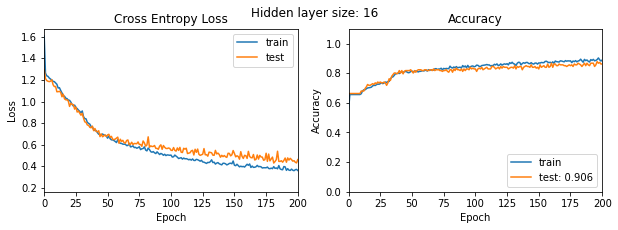

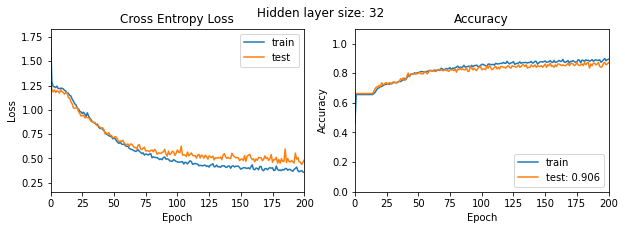

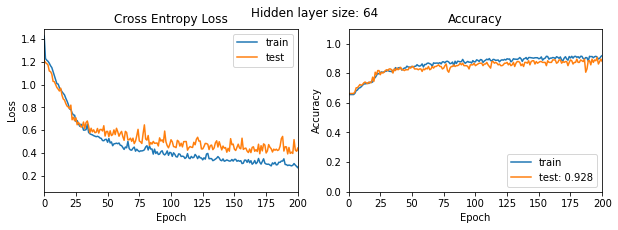

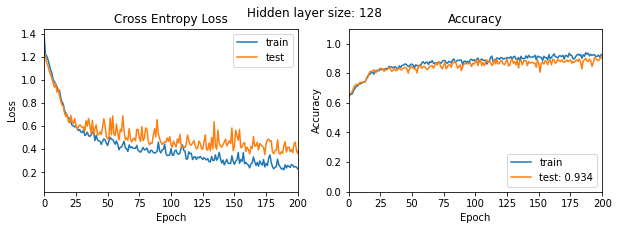

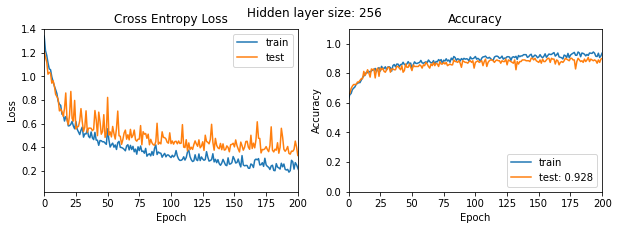

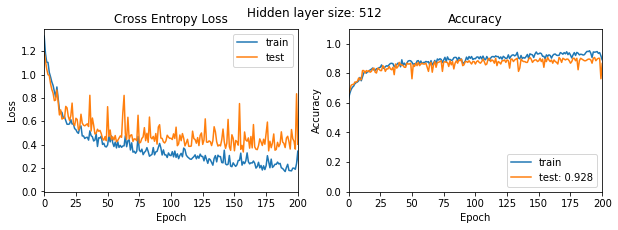

In [9]:
# Visualize model performances
for hl_size, inst in models.items():
    inst.visualize(figsize=(10,3), loss_range=200, acc_range=200)

In [12]:
# Compare final losses & accuracies across diff hidden layer sizes
keys = ['Hidden layer size', 'Loss (Train)', 'Loss (Test)', 'Accuracy (Train)', 'Accuracy (Test)']
df_dict = { k:[] for k in keys }

for hl_size, inst in models.items():
    df_dict[keys[0]].append(hl_size)
    df_dict[keys[1]].append(inst.train_losses[-1])
    df_dict[keys[2]].append(inst.test_losses[-1])
    df_dict[keys[3]].append(inst.train_accuracies[-1])
    df_dict[keys[4]].append(best_accuracies[hl_size])
    
df_metrics = pd.DataFrame(df_dict)
df_metrics.set_index(keys[0], inplace=True)
display(df_metrics)

,Loss (Train),Loss (Test),Accuracy (Train),Accuracy (Test)
Hidden layer size,,,,
16,0.244272,0.345042,0.934813,0.906077
32,0.236770,0.399610,0.927878,0.906077
64,0.134078,0.367941,0.962552,0.928177
128,0.099800,0.373979,0.965326,0.933702
256,0.095418,0.385517,0.970874,0.928177
512,0.125376,0.403197,0.961165,0.928177


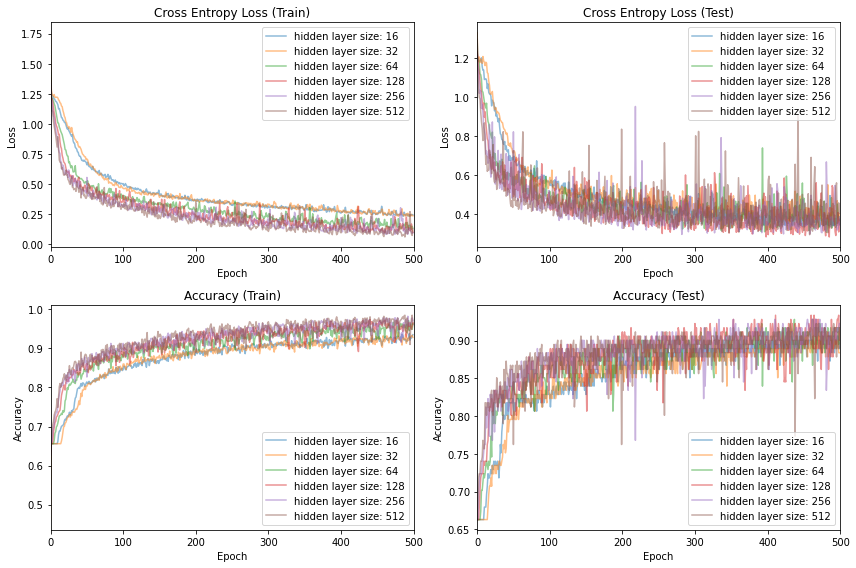

In [13]:
# Visualize losses & accuracies across diff hidden layer sizes
epochs = 500
targets = ["train_losses", "test_losses", "train_accuracies", "test_accuracies"]
titles = ["Cross Entropy Loss (Train)", "Cross Entropy Loss (Test)", "Accuracy (Train)", "Accuracy (Test)"]
ranges = [500, 500, 500, 500]

fig, axs = plt.subplots(2,2)
fig.set_size_inches(12,8)
# plt.subplots_adjust(top=0.94)

# Training loss
for i in range(4):
    row, col = i // 2, i % 2;
    for hl_size, inst in models.items(): 
        axs[row,col].plot([k for k in range(epochs)], getattr(inst, targets[i]), label="hidden layer size: %d" % hl_size, alpha=0.5)
    axs[row,col].set_title(titles[i])
    axs[row,col].set_xlim(0, ranges[i])
    axs[row,col].set_xlabel("Epoch")
    axs[row,col].set_ylabel("Accuracy" if row else "Loss")
    axs[row,col].legend(loc=("lower right" if row else "upper right"))

fig.tight_layout()
plt.show()

In [155]:
# save best model
torch.save(dd[128].model, './trained_models/FCNN_model.pt')

# 5. Testing Models

In [15]:
import random
import math

In [16]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [17]:
# Functions for finding vector magnitude and direction
def mag(pointA, pointB):
    x = pointA[0] - pointB[0]
    y = pointA[1] - pointB[1]
    return math.sqrt(x*x + y*y)

# find angle between two points (-pi to pi rads)
def angle(cog, point):
    x = point[0] - cog[0]
    y = point[1] - cog[1]
    
    if not x:
        return math.pi/2 if y>0 else -math.pi/2
        
    angle = math.atan(y/x)
    if x<0 and y>0: # 2nd quadrant
        angle += math.pi
    elif x<0 and y<0: # 3rd quadrant
        angle -= math.pi
    return angle

In [173]:
# get all image filenames
image_filenames = []
for root, dirs, files in os.walk(data_path):
    dirc = os.path.basename(root)
    if dirc != "contempt":
        for file in files:
            image_filenames += [data_path + dirc + '/' + file]        

In [156]:
# load models
fcnn_model = torch.load('./trained_models/FCNN_model.pt')
fcnn_model.eval()

FCNNModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=272, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=7, bias=True)
  )
)

dataset/ck/neutral/S112_005_00000001.png


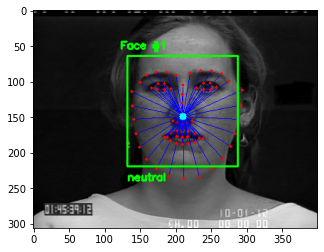

dataset/ck/sadness/S014_002_00000016.png


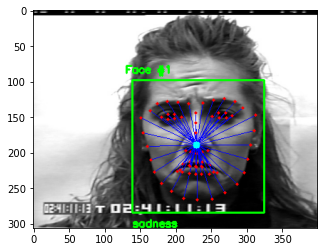

dataset/ck/surprise/S073_001_00000013.png


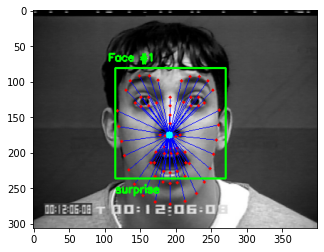

dataset/ck/happiness/S124_007_00000024.png


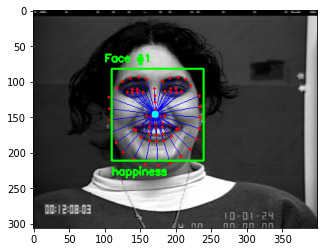

dataset/ck/neutral/S096_003_00000001.png


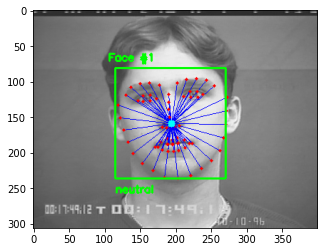

dataset/ck/neutral/S126_001_00000001.png


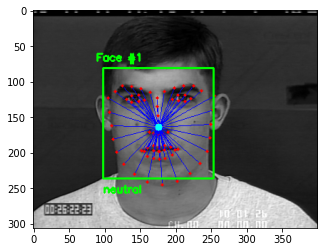

dataset/ck/neutral/S034_001_00000001.png


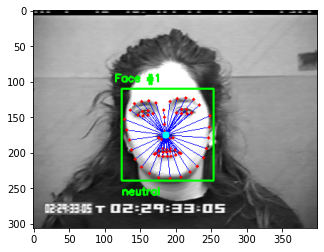

dataset/ck/neutral/S125_004_00000001.png


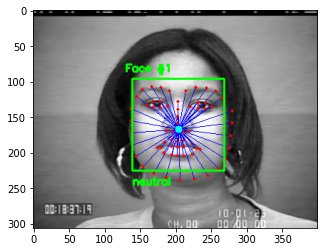

dataset/ck/happiness/S075_006_00000025.png


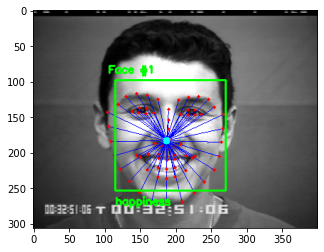

dataset/ck/neutral/S125_007_00000001.png


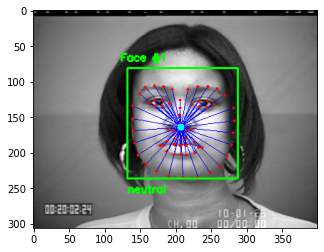

In [175]:
rand_images = random.sample(image_filenames, 10) # get random images  

for path in rand_images:   
    vectors, coords = [], []

    image = cv2.imread(path)
    image = imutils.resize(image, width=400)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    rects = detector(gray, 1)         

    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)        

        cog = tuple(shape.mean(axis=0).astype(int)) # get center of gravity (COG)            
        for (x,y) in shape:
            cv2.line(image, (x,y), cog, (0,0,255), 1) # draw vector lines
            cv2.circle(image, (x,y), 2, (255,0,0), -1) # image, center-coords, radius, colour, thickness(fill)
            vectors.append([mag(cog, (x,y)), angle(cog, (x,y))]) # get vector magnitude and direction                
            coords.append([x-cog[0], y-cog[1]]) # append coordinates relative to cog
            cv2.circle(image, cog, 5, (0,255,255), -1)    
            
        (x,y,w,h) = face_utils.rect_to_bb(rect) # convert dlib's rectangle to a OpenCV-style bounding box [i.e., (x,y,w,h)]
        cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2) # draw the face bounding box
        cv2.putText(image, "Face #{}".format(i+1), (x-10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2) # show face number

    vectors = np.array(vectors)        
    scale_factor = 1 / max(vectors[:,0])
    vectors[:,0] = vectors[:,0] * scale_factor # normalize magnitudes
    coords = np.array(coords) * scale_factor
    coords = coords.reshape(-1)   
    
    # prediction
    fcnn_input = np.dstack((vectors.reshape(1, -1), coords)).reshape(1, -1) # shape=(1, 272)
    with torch.no_grad():
        pred_tensor = fcnn_model(torch.Tensor(fcnn_input).cuda()).argmax()        
        pred = pred_tensor.cpu().numpy().item()
    pred_label = mood_map[pred]
    cv2.putText(image, '%s' % pred_label, (x,y+h+20),
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
    
    print(path)
    plt.imshow(image) # adapted for jupyter
    plt.show()